In [25]:
from oddt.toolkits import ob
from joblib import delayed, Parallel
from functools import partial
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from scipy import stats

import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

PDBBIND_DIR = '/home/fergus/pdbbind/v2019'
with open('../data/pdbbind_training_set.txt') as f:
    pdbs = [l.strip() for l in f]
with open('../data/pdbbind_training_set.txt') as f:
    train_pdbs = [l.strip() for l in f]
    
%matplotlib inline

plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [3]:
from oddt.scoring.descriptors import close_contacts_descriptor
ligand_atomic_nums = [6, 7, 8, 9, 15, 16, 17, 35, 53]
protein_atomic_nums = [6, 7, 8, 16]
cutoff = [0, 2, 4, 6, 8, 10, 12]
descriptors_func = close_contacts_descriptor(cutoff=cutoff,protein_types=protein_atomic_nums,ligand_types=ligand_atomic_nums)

@delayed
def build(pdb):
    protein = next(ob.readfile('pdb', f'{PDBBIND_DIR}/{pdb}/{pdb}_protein.pdb'))
    protein.protein = True
    # crystal
    ligand = next(ob.readfile('sdf', f'{PDBBIND_DIR}/{pdb}/{pdb}_ligand.sdf'))
    features_c = descriptors_func.build(ligand, protein)[0]

    # docked        
    ligand = next(ob.readfile('sdf', f'../pdbbind_docked_poses/{pdb}/{pdb}_ligand_docked.sdf'))
    features_d = descriptors_func.build(ligand, protein)[0]
    return (features_c, features_d)

In [8]:
with Parallel(n_jobs=6, verbose=10) as parallel:
    features = parallel(build(pdb) for pdb in pdbs)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    4.3s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.3s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   15.3s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   21.1s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   31.0s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   32.8s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   35.8s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   40.9s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   49.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   56.9s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  1.5min
[Parallel(

In [12]:
features_crystal = {}
features_docked = {}

for feature, pdb in zip(features, pdbs):
    features_crystal[pdb] = feature[0]
    features_docked[pdb] = feature[1]

In [14]:
with open('pdbbind_training_set_docked_rfv2.json', 'w') as f:
    json.dump(features_docked, f, cls=NumpyEncoder)
    
with open('pdbbind_training_set_crystal_rfv2.json', 'w') as f:
    json.dump(features_crystal, f, cls=NumpyEncoder)

In [2]:
with open('../data/pdbbind_test_set.txt') as f:
    test_pdbs = [l.strip() for l in f]

In [38]:
with Parallel(n_jobs=6, verbose=10) as parallel:
    test_features = parallel(build(pdb) for pdb in test_pdbs)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


NameError: name 'build' is not defined

In [23]:
test_features_crystal = {}
test_features_docked = {}

for feature, pdb in zip(test_features, test_pdbs):
    test_features_crystal[pdb] = feature[0]
    test_features_docked[pdb] = feature[1]
    
with open('pdbbind_test_set_docked_rfv2.json', 'w') as f:
    json.dump(test_features_docked, f, cls=NumpyEncoder)
    
with open('pdbbind_test_set_crystal_rfv2.json', 'w') as f:
    json.dump(test_features_crystal, f, cls=NumpyEncoder)

In [4]:
pdbbind_training_set_affinity = pd.read_csv('../data/pdbbind_training_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
pdbbind_test_set_affinity = pd.read_csv('../data/pdbbind_test_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)

In [8]:
features_docked = pd.Series(features_docked)

In [5]:
with open('pdbbind_training_set_docked_rfv2.json') as f:
    features_docked = json.load(f)
features_docked = pd.DataFrame(features_docked).T
with open('pdbbind_training_set_crystal_rfv2.json') as f:
    features_crystal = json.load(f)
features_crystal = pd.DataFrame(features_crystal).T

In [87]:
a=pd.DataFrame({'Crystal': {'RFv2': 0.760, 'RFv2 + Ligand': 0.787}, 'Docked': {'RFv2': 0.723, 'RFv2 + Ligand': 0.768}}).T

In [88]:
b=pd.DataFrame({'Crystal': {'RFv3': 0.765, 'RFv3 + Ligand': 0.785}, 'Docked': {'RFv3': 0.692, 'RFv3 + Ligand': 0.756}}).T

In [91]:
c=pd.DataFrame({'Crystal': {'PLEC': 0.689}, 'Docked': {'PLEC': 0.645}}).T

In [93]:
pd.concat([a,b,c], axis='columns')

,RFv2,RFv2 + Ligand,RFv3,RFv3 + Ligand,PLEC
Crystal,0.760,0.787,0.765,0.785,0.689
Docked,0.723,0.768,0.692,0.756,0.645


In [7]:
with open('pdbbind_test_set_crystal_rfv2.json') as f:
    test_features_crystal = pd.DataFrame(json.load(f)).T    
with open('pdbbind_test_set_docked_rfv2.json') as f:
    test_features_docked = pd.DataFrame(json.load(f)).T

In [6]:
pdbbind_training_set_affinity = pd.read_csv('../data/pdbbind_training_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
pdbbind_test_set_affinity = pd.read_csv('../data/pdbbind_test_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)

In [8]:
pdbbind_training_set = pdbbind_training_set_affinity.index
pdbbind_test_set = pdbbind_test_set_affinity.index

In [9]:
blast_clusters = {}
for cutoff in [30, 40, 50, 70, 90, 95, 100]:
    with open(f'../data/bc-{cutoff}.out') as f:
        blast_clusters[cutoff] = [set(item[:4].lower() for item in line.strip().split()) for line in f]

test_set_similar_pdbs = {}
for cutoff in blast_clusters:
    pdbs = set()
    for pdb in pdbbind_test_set:
        for cluster in blast_clusters[cutoff]:
            if pdb in cluster:
                pdbs.update(cluster)
    test_set_similar_pdbs[cutoff] = pd.Index(pdbs).intersection(pdbbind_training_set)

test_set_similar_pdbs['All'] = pd.Index([])

In [10]:
with open('../data/pdbbind_ligand_tanimoto_similarity.json') as f:
    tanimoto_similarity = json.load(f)

tc_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

test_set_similar_ligands = {}

for t in tc_thresholds:
    similar = set()
    for pdb_test in pdbbind_test_set:
        for pdb_train in pdbbind_training_set:
            if pdb_train in similar:
                continue
            if tanimoto_similarity[pdb_test][pdb_train] >= t:
                similar.add(pdb_train)
    test_set_similar_ligands[t] = pd.Index(similar)
test_set_similar_ligands['All'] = pd.Index([])

In [19]:
%%time
predicted_crystal_sequence_identity = {}
predicted_docked_sequence_identity = {}
pearsonr_crystal_sequence_identity = {}
pearsonr_docked_sequence_identity = {}

for cutoff in test_set_similar_pdbs:
    print(cutoff)
    training_set = pdbbind_training_set.difference(test_set_similar_pdbs[cutoff])
    y_train = pdbbind_training_set_affinity.loc[training_set].values.ravel()
    X_train_crystal = features_crystal.loc[training_set].values
    X_train_docked = features_docked.loc[training_set].values
    X_test_crystal = test_features_crystal.loc[pdbbind_test_set].values
    X_test_docked = test_features_docked.loc[pdbbind_test_set].values
    y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set].values.ravel()
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    
    predicted_crystal_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]

30
40
50
70
90
95
100
All
CPU times: user 4min 30s, sys: 2.35 s, total: 4min 33s
Wall time: 47.5 s


In [14]:
%%time
predicted_crystal_tanimoto = {}
predicted_docked_tanimoto = {}
pearsonr_crystal_tanimoto = {}
pearsonr_docked_tanimoto = {}

for cutoff in test_set_similar_ligands:
    print(cutoff)
    training_set = pdbbind_training_set.difference(test_set_similar_ligands[cutoff])
    y_train = pdbbind_training_set_affinity.loc[training_set].values.ravel()
    X_train_crystal = features_crystal.loc[training_set].values
    X_train_docked = features_docked.loc[training_set].values
    X_test_crystal = test_features_crystal.loc[pdbbind_test_set].values
    X_test_docked = test_features_docked.loc[pdbbind_test_set].values
    y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set].values.ravel()
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    
    predicted_crystal_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_tanimoto[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_tanimoto[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]

0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
All
CPU times: user 6min 51s, sys: 3.21 s, total: 6min 54s
Wall time: 1min 14s


In [12]:
lb_features = pd.read_csv('lb_features.csv', index_col=0)

In [20]:
%%time
predicted_crystal_rdk_sequence_identity = {}
predicted_docked_rdk_sequence_identity = {}
pearsonr_crystal_rdk_sequence_identity = {}
pearsonr_docked_rdk_sequence_identity = {}

for cutoff in test_set_similar_pdbs:
    print(cutoff)
    training_set = pdbbind_training_set.difference(test_set_similar_pdbs[cutoff])
    y_train = pdbbind_training_set_affinity.loc[training_set].values.ravel()
    X_train_crystal = features_crystal.loc[training_set]
    X_train_docked = features_docked.loc[training_set]
    X_test_crystal = test_features_crystal.loc[pdbbind_test_set]
    X_test_docked = test_features_docked.loc[pdbbind_test_set]
    y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set].values.ravel()
    # add lb features
    X_train_crystal = pd.concat([X_train_crystal, lb_features.loc[training_set]], axis='columns')
    X_test_crystal = pd.concat([X_test_crystal, lb_features.loc[pdbbind_test_set]], axis='columns')
    X_train_docked = pd.concat([X_train_docked, lb_features.loc[training_set]], axis='columns')
    X_test_docked = pd.concat([X_test_docked, lb_features.loc[pdbbind_test_set]], axis='columns')
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    
    predicted_crystal_rdk_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_rdk_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_rdk_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_rdk_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]

30
40
50
70
90
95
100
All
CPU times: user 9min 56s, sys: 2.43 s, total: 9min 58s
Wall time: 1min 34s


In [15]:
%%time
predicted_crystal_rdk_tanimoto = {}
predicted_docked_rdk_tanimoto = {}
pearsonr_crystal_rdk_tanimoto = {}
pearsonr_docked_rdk_tanimoto = {}

for cutoff in test_set_similar_ligands:
    print(cutoff)
    training_set = pdbbind_training_set.difference(test_set_similar_ligands[cutoff])
    y_train = pdbbind_training_set_affinity.loc[training_set].values.ravel()
    X_train_crystal = features_crystal.loc[training_set]
    X_train_docked = features_docked.loc[training_set]
    X_test_crystal = test_features_crystal.loc[pdbbind_test_set]
    X_test_docked = test_features_docked.loc[pdbbind_test_set]
    y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set].values.ravel()
    # add lb features
    X_train_crystal = pd.concat([X_train_crystal, lb_features.loc[training_set]], axis='columns')
    X_test_crystal = pd.concat([X_test_crystal, lb_features.loc[pdbbind_test_set]], axis='columns')
    X_train_docked = pd.concat([X_train_docked, lb_features.loc[training_set]], axis='columns')
    X_test_docked = pd.concat([X_test_docked, lb_features.loc[pdbbind_test_set]], axis='columns')
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    
    predicted_crystal_rdk_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_rdk_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_rdk_tanimoto[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_rdk_tanimoto[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]

0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
All
CPU times: user 15min 45s, sys: 3.67 s, total: 15min 49s
Wall time: 2min 30s


In [ ]:
with open('RFv2_predicted_crystal_sequence_identity.json', 'w') as f:
    json.dump(predicted_crystal_sequence_identity, f, cls=NumpyEncoder)
with open('RFv2_predicted_docked_sequence_identity.json', 'w') as f:
    json.dump(predicted_docked_sequence_identity, f, cls=NumpyEncoder)
with open('RFv2_pearsonr_crystal_sequence_identity.json', 'w') as f:
    json.dump(pearsonr_crystal_sequence_identity, f, cls=NumpyEncoder)
with open('RFv2_pearsonr_docked_sequence_identity.json', 'w') as f:
    json.dump(pearsonr_docked_sequence_identity, f, cls=NumpyEncoder)

In [16]:
with open('RFv2_predicted_crystal_tanimoto.json', 'w') as f:
    json.dump(predicted_crystal_tanimoto, f, cls=NumpyEncoder)
with open('RFv2_predicted_docked_tanimoto.json', 'w') as f:
    json.dump(predicted_docked_tanimoto, f, cls=NumpyEncoder)
with open('RFv2_pearsonr_crystal_tanimoto.json', 'w') as f:
    json.dump(pearsonr_crystal_tanimoto, f, cls=NumpyEncoder)
with open('RFv2_pearsonr_docked_tanimoto.json', 'w') as f:
    json.dump(pearsonr_docked_tanimoto, f, cls=NumpyEncoder)

In [13]:
with open('RFv2_RDK_predicted_crystal_sequence_identity.json', 'w') as f:
    json.dump(predicted_crystal_rdk_sequence_identity, f, cls=NumpyEncoder)
with open('RFv2_RDK_predicted_docked_sequence_identity.json', 'w') as f:
    json.dump(predicted_docked_rdk_sequence_identity, f, cls=NumpyEncoder)
with open('RFv2_RDK_pearsonr_crystal_sequence_identity.json', 'w') as f:
    json.dump(pearsonr_crystal_rdk_sequence_identity, f, cls=NumpyEncoder)
with open('RFv2_RDK_pearsonr_docked_sequence_identity.json', 'w') as f:
    json.dump(pearsonr_docked_rdk_sequence_identity, f, cls=NumpyEncoder)

In [17]:
with open('RFv2_RDK_predicted_crystal_tanimoto.json', 'w') as f:
    json.dump(predicted_crystal_rdk_tanimoto, f, cls=NumpyEncoder)
with open('RFv2_RDK_predicted_docked_tanimoto.json', 'w') as f:
    json.dump(predicted_docked_rdk_tanimoto, f, cls=NumpyEncoder)
with open('RFv2_RDK_pearsonr_crystal_tanimoto.json', 'w') as f:
    json.dump(pearsonr_crystal_rdk_tanimoto, f, cls=NumpyEncoder)
with open('RFv2_RDK_pearsonr_docked_tanimoto.json', 'w') as f:
    json.dump(pearsonr_docked_rdk_tanimoto, f, cls=NumpyEncoder)

In [28]:
import statistical_tests as st

pearsonr_ci_crystal_si = {}
pearsonr_ci_docked_si = {}
pearsonr_pval_crystal_si = {}
pearsonr_pval_docked_si = {}

y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set]
for cutoff in predicted_crystal_sequence_identity:
    y_pred = pd.Series(predicted_crystal_sequence_identity[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_crystal_si[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_crystal_si[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    y_pred = pd.Series(predicted_docked_sequence_identity[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_docked_si[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_docked_si[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    
pearsonr_ci_crystal_tanimoto = {}
pearsonr_ci_docked_tanimoto = {}
pearsonr_pval_crystal_tanimoto = {}
pearsonr_pval_docked_tanimoto = {}

y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set]
for cutoff in predicted_crystal_tanimoto:
    y_pred = pd.Series(predicted_crystal_tanimoto[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_crystal_tanimoto[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_crystal_tanimoto[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    y_pred = pd.Series(predicted_docked_tanimoto[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_docked_tanimoto[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_docked_tanimoto[cutoff] = st.permutation_pearsonr(y_test, y_pred)

In [29]:
pearsonr_ci_crystal_rdk_si = {}
pearsonr_ci_docked_rdk_si = {}
pearsonr_pval_crystal_rdk_si = {}
pearsonr_pval_docked_rdk_si = {}

y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set]
for cutoff in predicted_crystal_rdk_sequence_identity:
    y_pred = pd.Series(predicted_crystal_rdk_sequence_identity[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_crystal_rdk_si[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_crystal_rdk_si[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    y_pred = pd.Series(predicted_docked_rdk_sequence_identity[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_docked_rdk_si[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_docked_rdk_si[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    
pearsonr_ci_crystal_rdk_tanimoto = {}
pearsonr_ci_docked_rdk_tanimoto = {}
pearsonr_pval_crystal_rdk_tanimoto = {}
pearsonr_pval_docked_rdk_tanimoto = {}

y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set]
for cutoff in predicted_crystal_rdk_tanimoto:
    y_pred = pd.Series(predicted_crystal_rdk_tanimoto[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_crystal_rdk_tanimoto[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_crystal_rdk_tanimoto[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    y_pred = pd.Series(predicted_docked_rdk_tanimoto[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_docked_rdk_tanimoto[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_docked_rdk_tanimoto[cutoff] = st.permutation_pearsonr(y_test, y_pred)

In [30]:
pearsonr_ci_docked_si

{30: (0.6017250326225199, 0.5472651092532687, 0.6494707972898969),
 40: (0.625061569381103, 0.5737299816226646, 0.6701123399893059),
 50: (0.6467371376560738, 0.5962186814173441, 0.6922748197440538),
 70: (0.6571838075929747, 0.6071673312065491, 0.7019738576172173),
 90: (0.6583105271350007, 0.6074078940875324, 0.70384639567786),
 95: (0.6644401074982037, 0.6150847650605079, 0.7087970754391797),
 100: (0.6711938918265582, 0.6224757646130584, 0.7156810918213892),
 'All': (0.7277760625790546, 0.6833966490809329, 0.7674938779317796)}

In [31]:
pearsonr_ci_docked_rdk_si

{30: (0.6491826777008375, 0.6006344202899363, 0.692061474471113),
 40: (0.6790899453066984, 0.6324033265202267, 0.7198742512926497),
 50: (0.6856081332768335, 0.6384033666156828, 0.7272795012756614),
 70: (0.6986381161783477, 0.6535612049668452, 0.7387184910512768),
 90: (0.7054965580858032, 0.6601241266653127, 0.7456423838092754),
 95: (0.7042955768791124, 0.6588389636951001, 0.7446330253519398),
 100: (0.7194347700562517, 0.6763743478901565, 0.7573385461455386),
 'All': (0.7675129221985081, 0.729262275220661, 0.8017221803681994)}

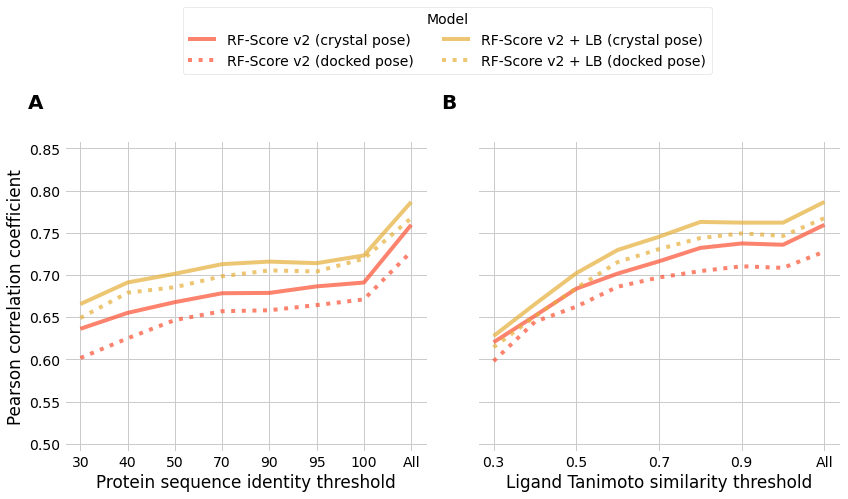

In [38]:
pearsonr_crystal_si = pd.Series({c: pearsonr_ci_crystal_si[c][0] for c in pearsonr_ci_crystal_si})
pearsonr_docked_si = pd.Series({c: pearsonr_ci_docked_si[c][0] for c in pearsonr_ci_docked_si})
pearsonr_crystal_rdk_si = pd.Series({c: pearsonr_ci_crystal_rdk_si[c][0] for c in pearsonr_ci_crystal_si})
pearsonr_docked_rdk_si = pd.Series({c: pearsonr_ci_docked_rdk_si[c][0] for c in pearsonr_ci_docked_si})

pearsonr_crystal_tc = pd.Series({c: pearsonr_ci_crystal_tanimoto[c][0] for c in pearsonr_ci_crystal_tanimoto})
pearsonr_docked_tc = pd.Series({c: pearsonr_ci_docked_tanimoto[c][0] for c in pearsonr_ci_docked_tanimoto})
pearsonr_crystal_rdk_tc = pd.Series({c: pearsonr_ci_crystal_rdk_tanimoto[c][0] for c in pearsonr_ci_crystal_tanimoto})
pearsonr_docked_rdk_tc = pd.Series({c: pearsonr_ci_docked_rdk_tanimoto[c][0] for c in pearsonr_ci_docked_tanimoto})

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6),sharey=True)

#colours = ['#008fd5', '#fc4f30', '#e5ae38']
colours = ['#fc4f30', '#e5ae38']

pearsonr_crystal_si.plot(ax=ax1, label='RF-Score v2 (crystal pose)', alpha=0.7, color=colours[0])
pearsonr_docked_si.plot(ax=ax1, label='RF-Score v2 (docked pose)', alpha=0.7, color=colours[0], linestyle=':')

pearsonr_crystal_rdk_si.plot(ax=ax1, label='RF-Score v2 + LB (crystal pose)', alpha=0.7, color=colours[1])
pearsonr_docked_rdk_si.plot(ax=ax1, label='RF-Score v2 + LB (docked pose)', alpha=0.7, color=colours[1], linestyle=':')

pearsonr_crystal_tc.plot(ax=ax2, label='RF-Score v2 (crystal pose)', alpha=0.7, color=colours[0])
pearsonr_docked_tc.plot(ax=ax2, label='RF-Score v2 (docked pose)', alpha=0.7, color=colours[0], linestyle=':')

pearsonr_crystal_rdk_tc.plot(ax=ax2, label='RF-Score v2 + LB (crystal pose)', alpha=0.7, color=colours[1])
pearsonr_docked_rdk_tc.plot(ax=ax2, label='RF-Score v2 + LB (docked pose)', alpha=0.7, color=colours[1], linestyle=':')

ax1.set_ylim(0.49, 0.86)
ax1.set_xlabel('Protein sequence identity threshold')
ax1.set_ylabel('Pearson correlation coefficient')

ax2.set_xlabel('Ligand Tanimoto similarity threshold')
ax2.set_ylabel('Pearson correlation coefficient')

#ax1.axhline(y=pearsonr_vina_docked, label='Vina (docked pose)', color='k', linestyle=':')
#ax2.axhline(y=pearsonr_vina_docked, label='Vina (docked pose)', color='k', linestyle=':')

for ax, annotation in zip((ax1,ax2), ['A', 'B']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()
ax1.legend(title='Model', bbox_to_anchor=(1.8, 1.45), ncol=2)

#fig.savefig('../figures/CASF_pearsonr_crystal_dock.png', dpi=350, bbox_inches='tight')